In [32]:
from collections import Counter
from typing import Dict
import json
from pprint import pprint


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import sys
sys.path.append("../")
from intercode.envs.swe import extract

# Log Analysis

In [3]:
swe_log_path = "../logs/experiments/swe_multiturn_claude_20_turns_240212-22:16:14_turn.json"
swe_log = json.load(open(swe_log_path, "r"))

# of queries: 20
# of total turns: 132
Avg # of turns per query: 6.6
Avg # of valid actions per query: 3.4


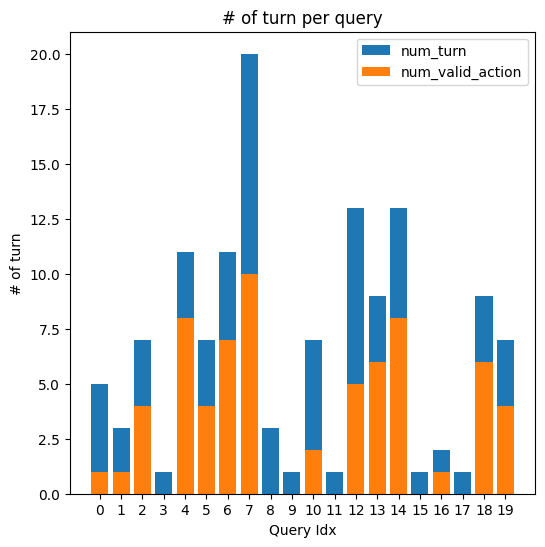

In [37]:
num_queries = len(swe_log)
num_turns = [len(v["turn_history"]["is_valid_action"]) for v in swe_log.values()]
num_valid_actions = [sum(v["turn_history"]["is_valid_action"]) for v in swe_log.values()]
print(f"# of queries: {num_queries}")
print(f"# of total turns: {sum(num_turns):.0f}")
print(f"Avg # of turns per query: {np.mean(num_turns):.1f}")
print(f"Avg # of valid actions per query: {np.mean(num_valid_actions):.1f}")

fig, ax = plt.subplots(1,1, figsize=(6, 6))
plt.bar(list(range(num_queries)), num_turns, label="num_turn")
plt.bar(list(range(num_queries)), num_valid_actions, label="num_valid_action")
plt.xticks(list(range(num_queries)))
plt.legend()
plt.title("# of turn per query")
plt.xlabel("Query Idx")
plt.ylabel("# of turn")
plt.show()

In [17]:
success_query_idxes =  [k for k, v in swe_log.items() if v["turn_history"]["reward"][-1] == 1]
print(f"# of success queries: {len(success_query_idxes)}")

# of success queries: 0


In [34]:
for idx in swe_log.keys():
    turn_history = swe_log[idx]["turn_history"]
    turn_history_commands = [extract.get_commands(action) for action in turn_history["action"]]
    swe_log[idx]["turn_history"]["commands"] = turn_history_commands

In [36]:
commands_with_valid = sum([list(zip(v["turn_history"]["commands"], v["turn_history"]["is_valid_action"])) for v in swe_log.values()], [])
assert sum(num_turns) == len(commands_with_valid)

132

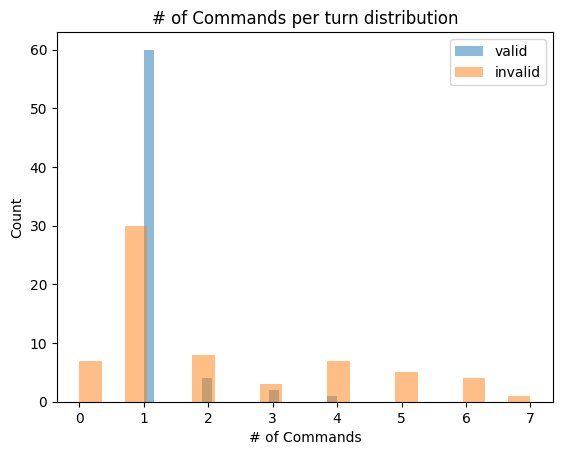

In [47]:
commands_is_valid = [commands for commands, is_valid in commands_with_valid if is_valid]
commands_is_invalid = [commands for commands, is_valid in commands_with_valid if not is_valid]

plt.hist([len(c) for c in commands_is_valid], bins=20, label="valid", alpha=.5)
plt.hist([len(c) for c in commands_is_invalid], bins=20, label="invalid", alpha=.5)
plt.ylabel("Count")
plt.xlabel("# of Commands")
plt.title("# of Commands per turn distribution")
plt.legend()
plt.show()

In [54]:
valid_command_types = sum([[c.type.value for c in cs] for cs in commands_is_valid], [])
invalid_command_types = sum([[c.type.value for c in cs] for cs in commands_is_invalid], [])

valid_command_types_counter = Counter(valid_command_types)
invalid_command_types_counter = Counter(invalid_command_types)

print("Valid commands counter")
print(valid_command_types_counter)
print("Invalid commands counter")
print(invalid_command_types_counter)

Valid commands counter
Counter({'SHELL': 69, 'SKIP': 8, 'PATCH': 1})
Invalid commands counter
Counter({'SHELL': 98, 'PATCH': 29, 'SUBMIT': 12})


In [66]:
valid_shell_contents = sum([[c.content for c in cs if c.type.value == "SHELL"] for cs in commands_is_valid], [])
valid_shell_start_counter = Counter([c.split(" ")[0] for c in valid_shell_contents])
valid_patch_contents = sum([[c.content for c in cs if c.type.value == "PATCH"] for cs in commands_is_valid], [])

In [67]:
print("valid_shell_start_counter")
pprint(valid_shell_start_counter)

valid_shell_start_counter
Counter({'ls': 18,
         'tree': 13,
         'cat': 12,
         'grep': 11,
         'cd': 5,
         'git': 4,
         'patch': 4,
         'man': 1,
         'find': 1})


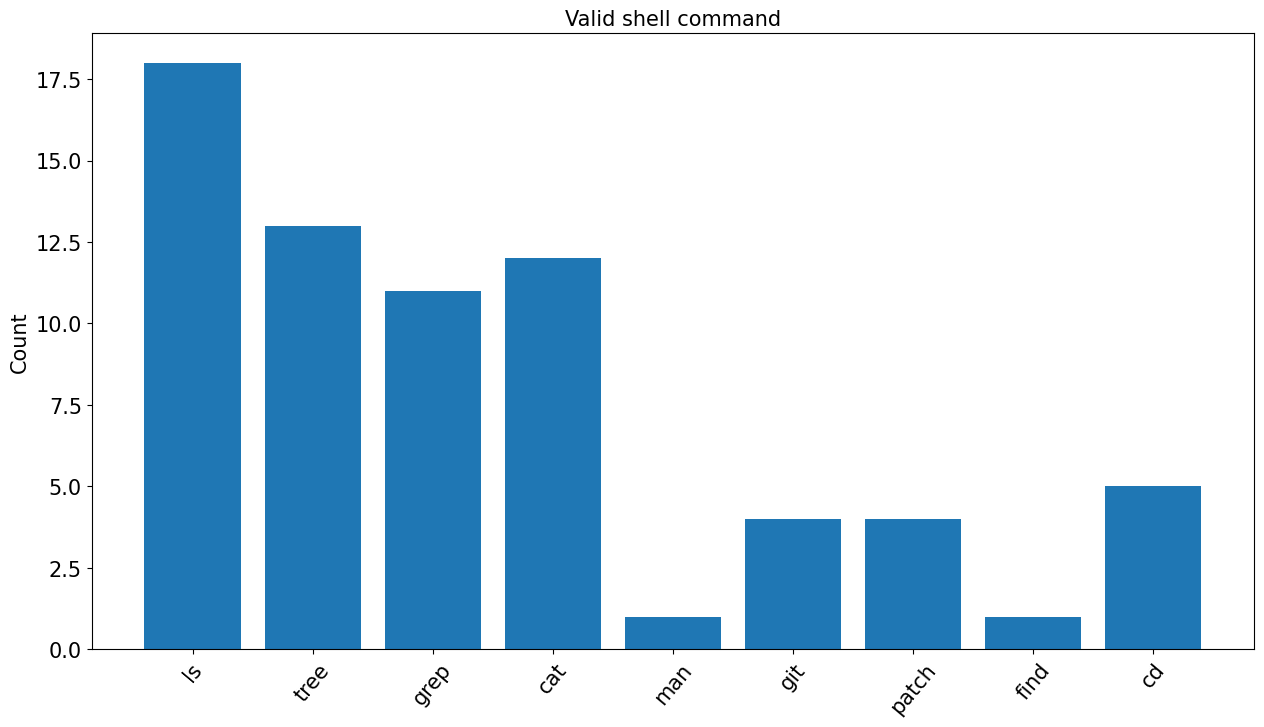

In [87]:
plt.subplots(1, 1, figsize=(15,8))
plt.bar(valid_shell_start_counter.keys(), valid_shell_start_counter.values())
plt.ylabel("Count", size=15)
plt.title("Valid shell command", size=15)
plt.xticks(rotation=50, size=15)
plt.yticks(size=15)
plt.show()

In [68]:
print("valid_patch_contents[0]:")
print(valid_patch_contents[0])

valid_patch_contents[0]:

diff --git a/src/sqlfluff/core/parser/parser.py b/src/sqlfluff/core/parser/parser.py
index a4221b3..4c76de1 100644
--- a/src/sqlfluff/core/parser/parser.py  
+++ b/src/sqlfluff/core/parser/parser.py
@@ -16,6 +16,9 @@ class Parser:
         # Allow optional config and dialect
         self.config = FluffConfig.from_kwargs(config=config, dialect=dialect)
         self.RootSegment = self.config.get("dialect_obj").get_root_segment()
+        
+        # Quick fix attempt for Jinja issues
+        self.jinja_tracer.reset() 
 
     def parse(
         self,



In [70]:
invalid_shell_contents = sum([[c.content for c in cs if c.type.value == "SHELL"] for cs in commands_is_invalid], [])
# some of the invalid ones are actually valid
invalid_shell_start_counter = Counter([c.split(" ")[0] for c in invalid_shell_contents])
invalid_patch_contents = sum([[c.content for c in cs if c.type.value == "PATCH"] for cs in commands_is_invalid], [])

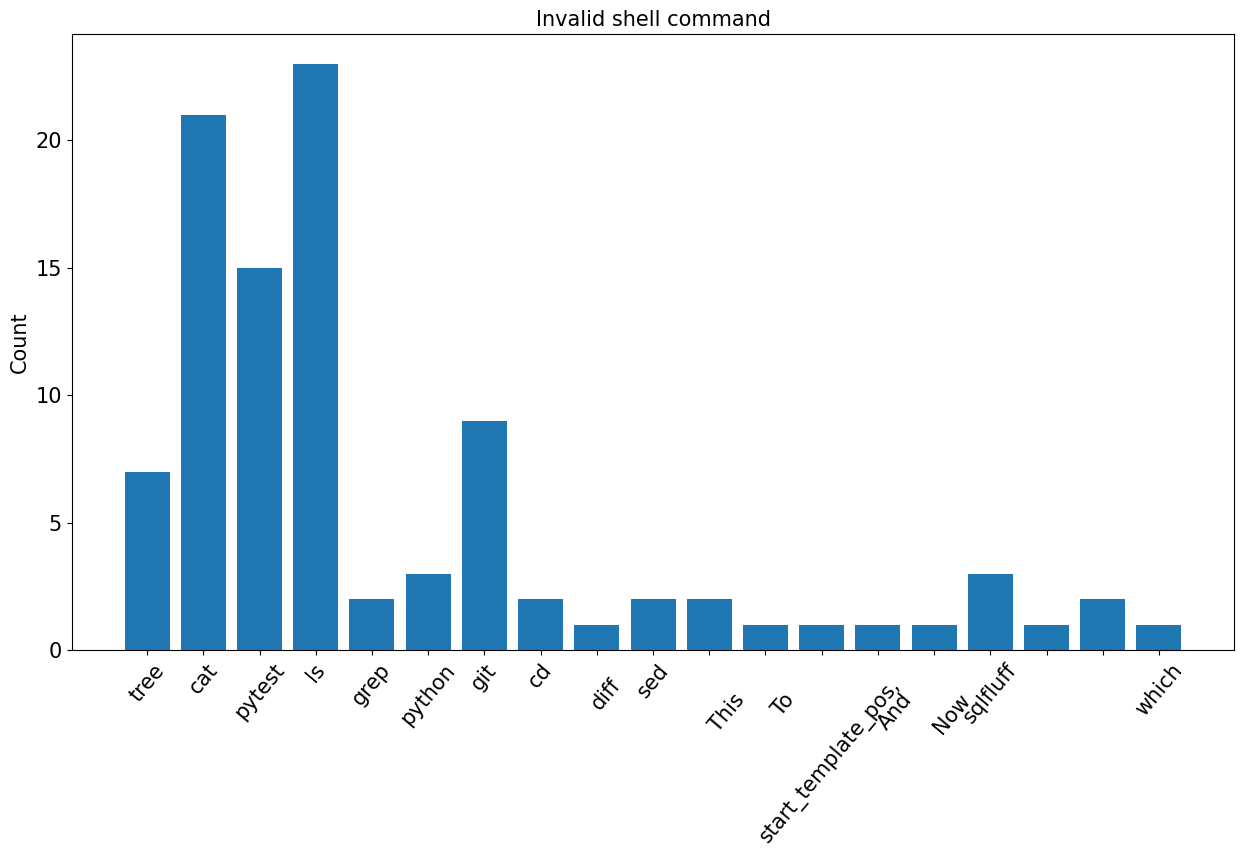

In [88]:
plt.subplots(1, 1, figsize=(15,8))
plt.bar(invalid_shell_start_counter.keys(), invalid_shell_start_counter.values())
plt.ylabel("Count", size=15)
plt.title("Invalid shell command", size=15)
plt.xticks(rotation=50, size=15)
plt.yticks(size=15)
plt.show()

In [89]:
pprint(invalid_shell_start_counter)

Counter({'ls': 23,
         'cat': 21,
         'pytest': 15,
         'git': 9,
         'tree': 7,
         'python': 3,
         'sqlfluff': 3,
         'grep': 2,
         'cd': 2,
         'sed': 2,
         '\n\nThis': 2,
         '\n\n': 2,
         '\ndiff': 1,
         '\n\nTo': 1,
         '\nstart_template_pos,': 1,
         '\n\nAnd': 1,
         '\n\nNow': 1,
         '\n': 1,
         'which': 1})


In [72]:
print("invalid_patch_contents[0]:")
print(invalid_patch_contents[0])

invalid_patch_contents[0]:

diff --git a/src/sqlfluff/cli/cli.py b/src/sqlfluff/cli/cli.py
index aaa1111..bbb2222 100644
--- a/src/sqlfluff/cli/cli.py  
+++ b/src/sqlfluff/cli/cli.py
@@ -10,6 +10,7 @@ def cli(verbose: int):
     2: verbose
     3: very verbose
     """
+    if verbose == 0:
+        # quiet mode
+        pass
     if verbose >= 1:
         print("Doing thing...")




In [98]:
def find_actions_and_observations(swe_log: dict, command_type:str="SHELL", command_content:str="\n"):
    result_actions = []
    result_observations = []
    for v in swe_log.values():
        turn_history = v["turn_history"]
        commands_per_turn = turn_history["commands"]
        actions = turn_history["action"]
        observations = turn_history["observation"]
        for action, observation, commands in zip(actions, observations, commands_per_turn):
            for command in commands:
                if command_type and command.type.value != command_type:
                    continue
                if command.content.startswith(command_content):
                    result_actions.append(action)
                    result_observations.append(observation)
                    break
    return result_actions, result_observations

In [99]:
command_type = "SHELL"
command_content = "\n"
actions, observations = find_actions_and_observations(swe_log, command_type, command_content)
print(f"# of actions following command type {command_type!r} and starts with content {command_content!r}: {len(actions)}")

# of actions following command type 'SHELL' and starts with content '\n': 7


In [100]:
for i, a in enumerate(actions):
    print("#" * 20 + f" {i} " + "#"*20)
    print("#" * 20 + f" ACTION " + "#"*20)
    print(a)
    print("#" * 20 + f" OBSERVATION " + "#"*20)
    print(observations[i])

#################### 0 ####################
#################### ACTION ####################
Hmm, still getting an error applying the patch. Let me double check that I have the patch format correct against the Github documentation:

https://docs.github.com/en/github/committing-changes-to-your-project/creating-and-editing-commits/creating-a-commit-with-multiple-authors

Based on the docs, it looks like my patch format is correct. I must still be missing some context or detail compared to the actual `commands.py` file.

Let me do a clean checkout of the code and try applying the patch from scratch:

SHELL: git clone https://github.com/sqlfluff/sqlfluff.git
SHELL: cd sqlfluff
SHELL: git checkout main
SHELL: patch -p1 < my_patch.txt

Where my_patch.txt contains:

```
diff --git a/src/sqlfluff/cli/commands.py b/src/sqlfluff/cli/commands.py
index a141f9d..02ac7d3 100644
--- a/src/sqlfluff/cli/commands.py
+++ b/src/sqlfluff/cli/commands.py
@@ -64,6 +64,13 @@
               help='The output fo

In [101]:
command_type = "SHELL"
command_content = "which"
actions, observations = find_actions_and_observations(swe_log, command_type, command_content)
print(f"# of actions following command type {command_type!r} and starts with content {command_content!r}: {len(actions)}")

# of actions following command type 'SHELL' and starts with content 'which': 1


In [102]:
for i, a in enumerate(actions):
    print("#" * 20 + f" {i} " + "#"*20)
    print("#" * 20 + f" ACTION " + "#"*20)
    print(a)
    print("#" * 20 + f" OBSERVATION " + "#"*20)
    print(observations[i])

#################### 0 ####################
#################### ACTION ####################
Hmm sqlfluff still isn't available even after pip installing. Let me check the python environment:

SHELL: which python

And try a more explicit install:

SHELL: python -m pip install sqlfluff

Then attempt the test command again:

SHELL: python -m sqlfluff lint test/fixtures/rules/jinja_if_indent.sql --config test/jinja_if_indent.cfg

If that still doesn't work, there may be something funky about this environment that prevents installing/running sqlfluff properly. 

At that point, I'd have to punt on actually testing a fix, but could still attempt a PR with the fix based on the issue description.

Let me know if the explicit python install and run works or if you have any other ideas!
#################### OBSERVATION ####################

Command 0 result:

Command 1 result:
/bin/bash: line 1: python: command not found

Command 2 result:
/bin/bash: line 1: python: command not found



## Case Analysis

In [18]:
idx = 0
query_log = swe_log[str(idx)]
query_log.keys()

dict_keys(['environment', 'dataset', 'task_id', 'query', 'turn_history'])

In [21]:
print("Query:")
print(query_log["query"])

Query:
Enable quiet mode/no-verbose in CLI for use in pre-commit hook
There seems to be only an option to increase the level of verbosity when using SQLFluff [CLI](https://docs.sqlfluff.com/en/stable/cli.html), not to limit it further.

It would be great to have an option to further limit the amount of prints when running `sqlfluff fix`, especially in combination with deployment using a pre-commit hook. For example, only print the return status and the number of fixes applied, similar to how it is when using `black` in a pre-commit hook:
![image](https://user-images.githubusercontent.com/10177212/140480676-dc98d00b-4383-44f2-bb90-3301a6eedec2.png)

This hides the potentially long list of fixes that are being applied to the SQL files, which can get quite verbose.



In [22]:
print("Gold Patch:")
# print(query_log["gold"])

Gold Patch:


In [23]:
query_log["turn_history"].keys()

dict_keys(['action', 'observation', 'reward', 'is_valid_action'])

In [24]:
query_log["turn_history"]["is_valid_action"]

[True, False, False, False, False]